# Software development progress indicators

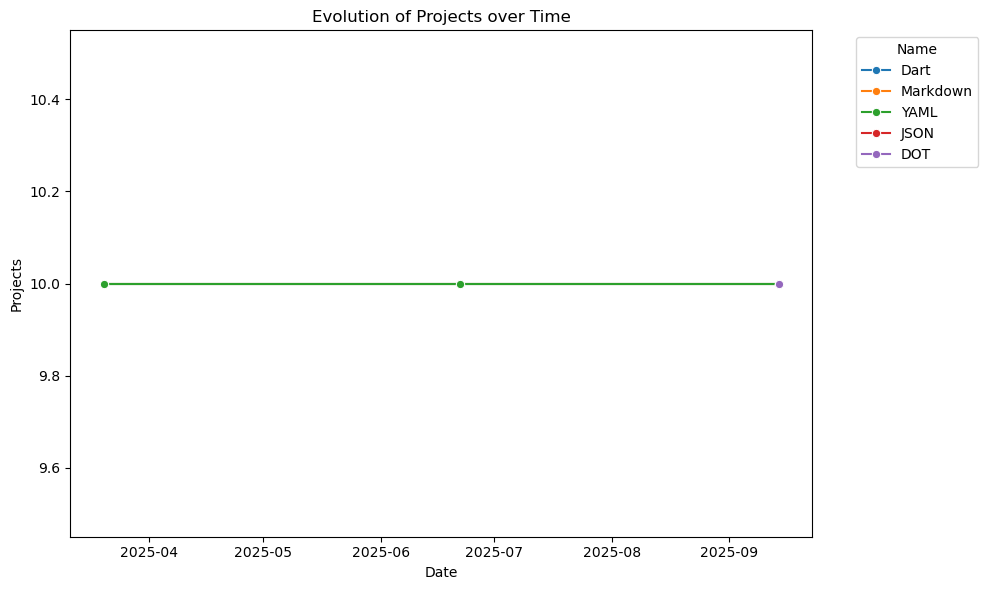

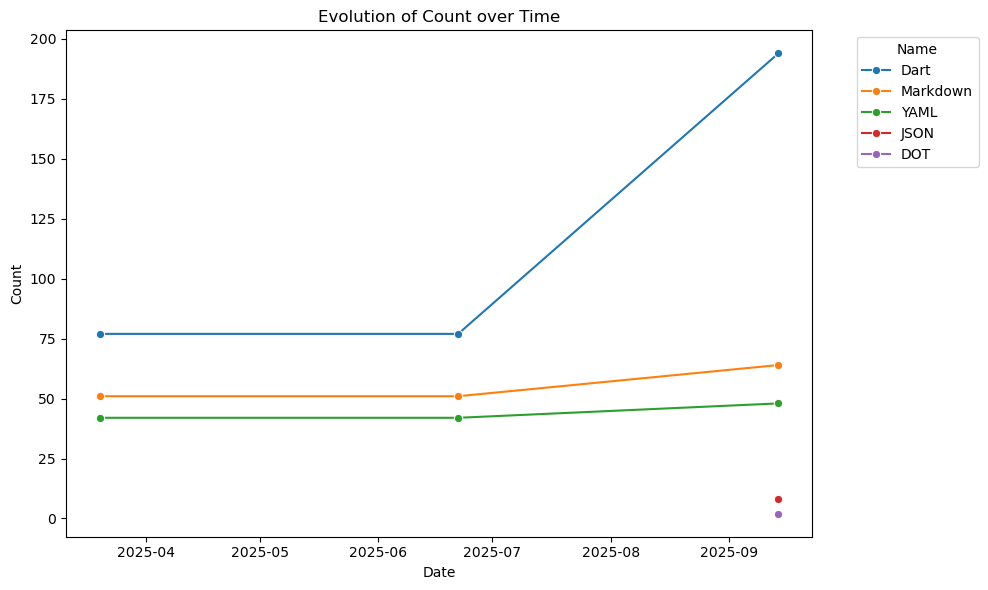

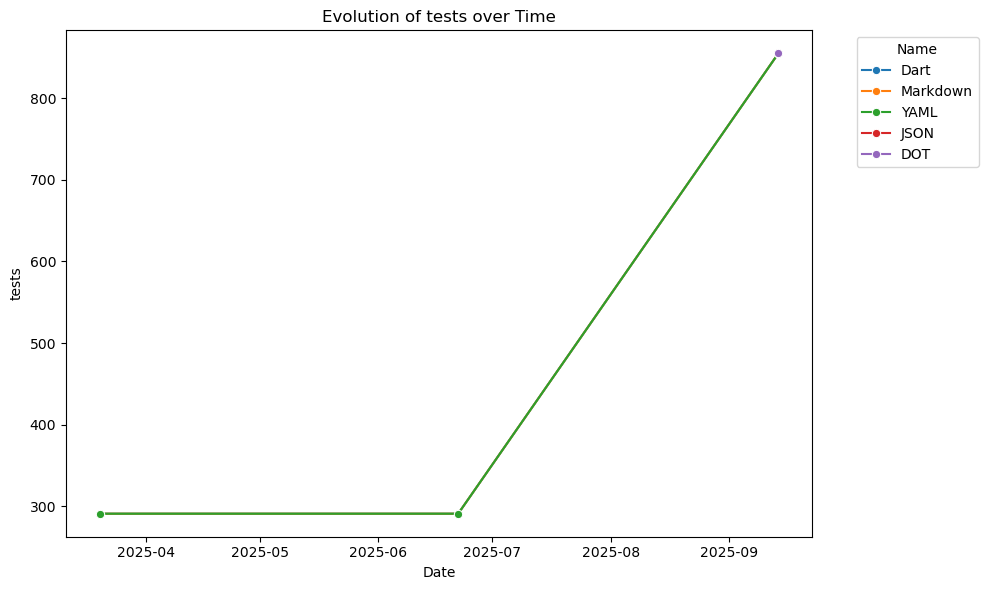

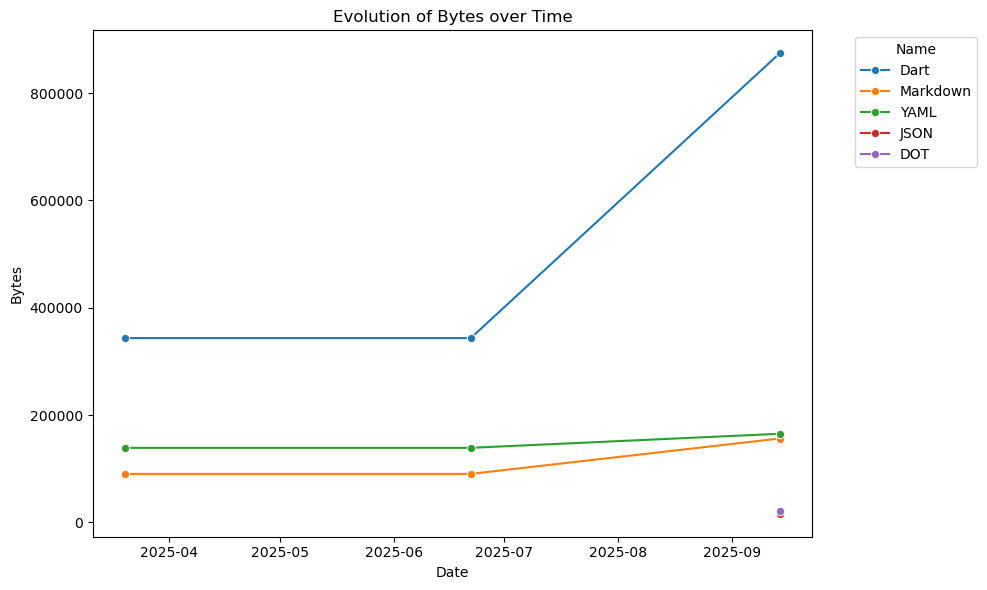

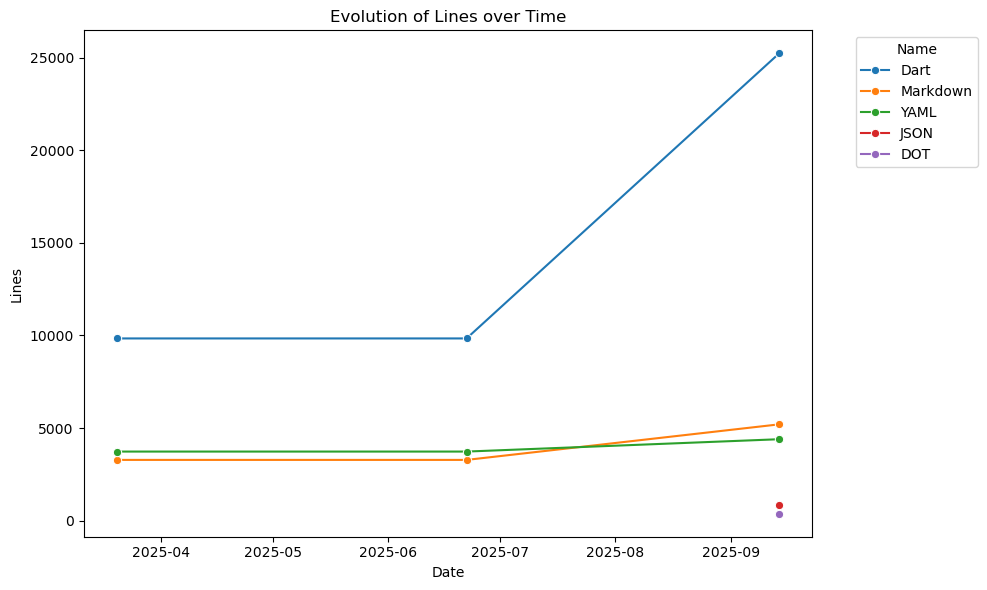

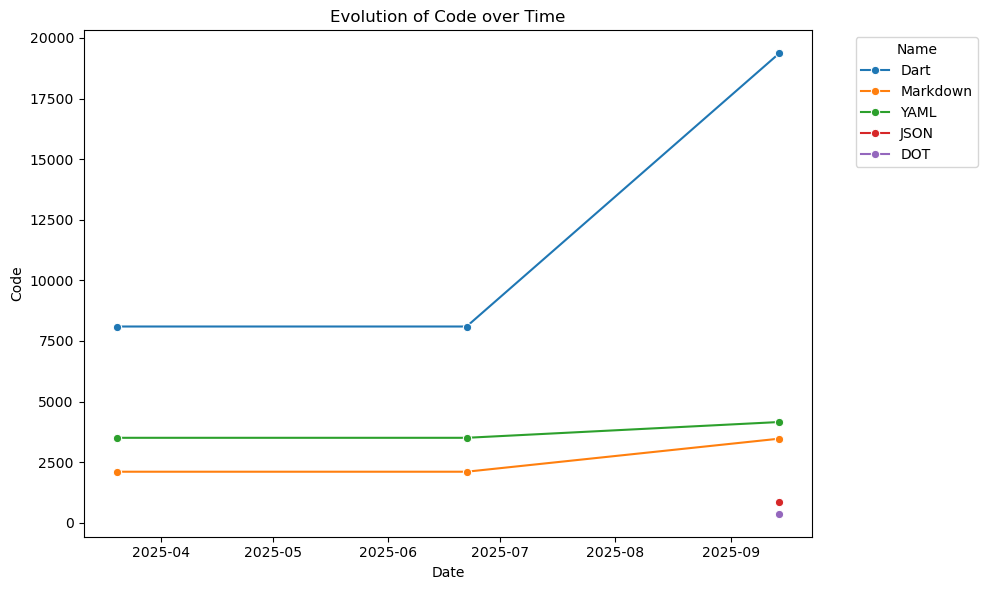

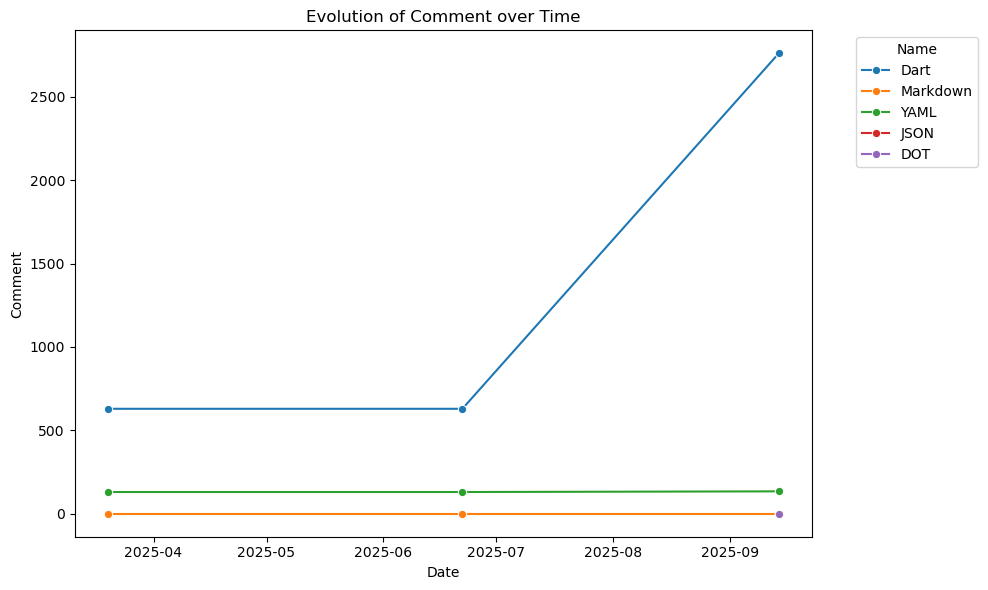

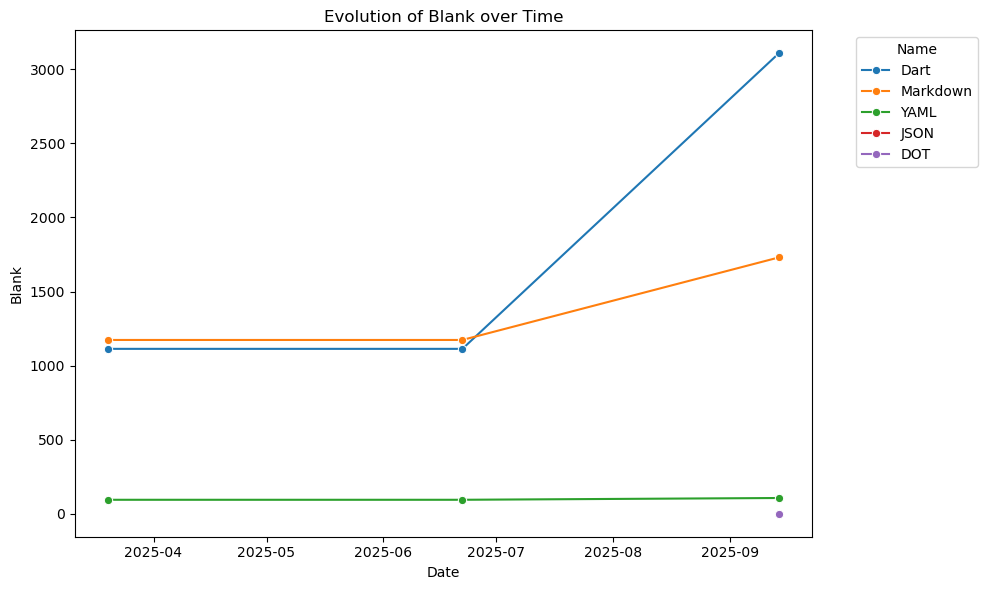

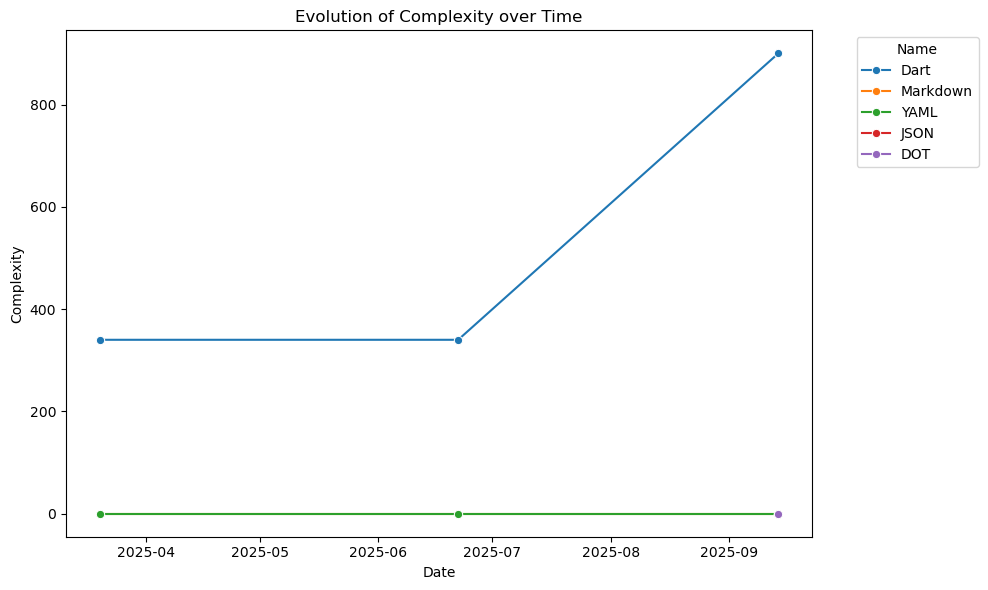

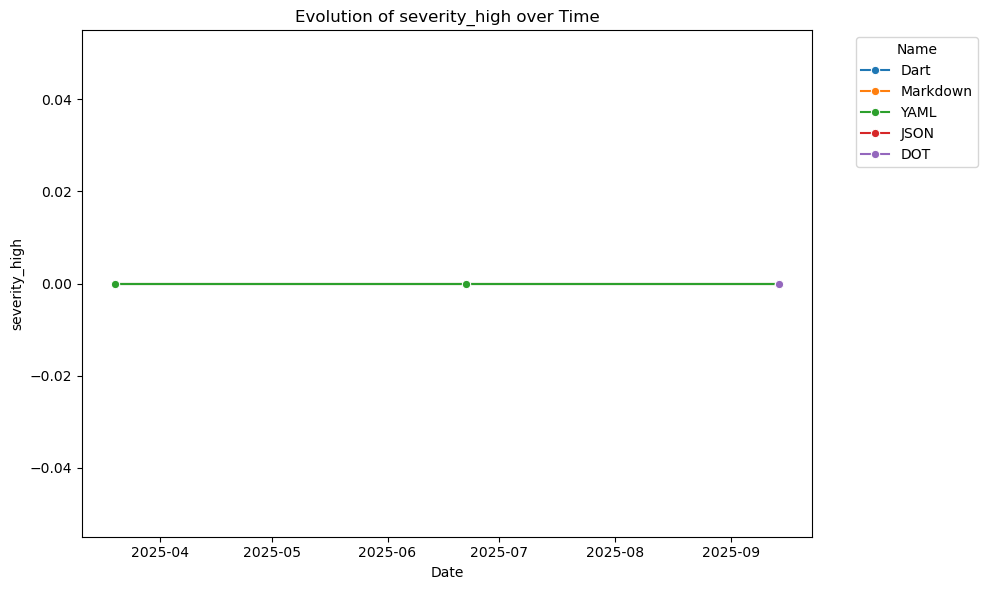

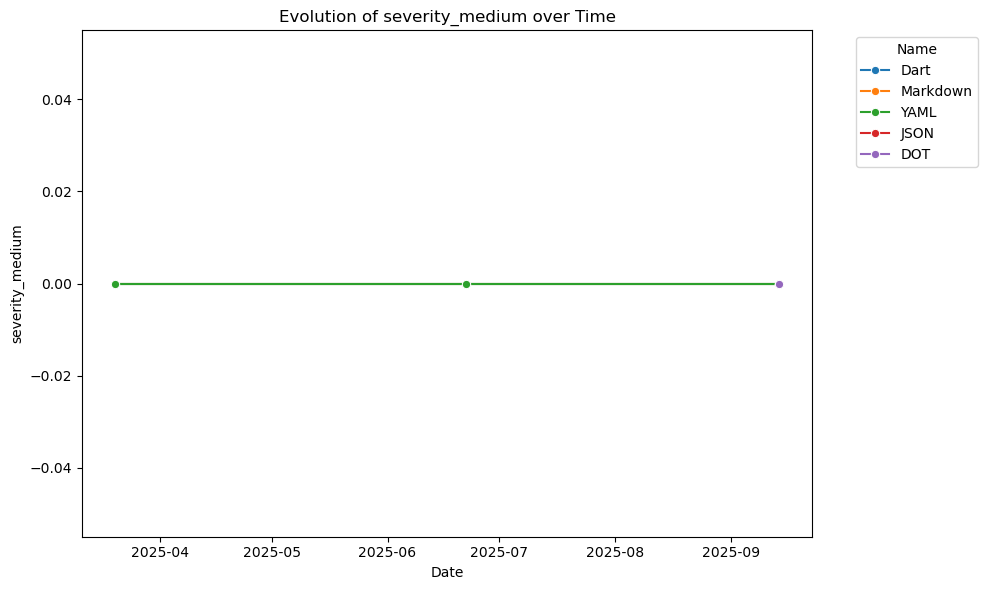

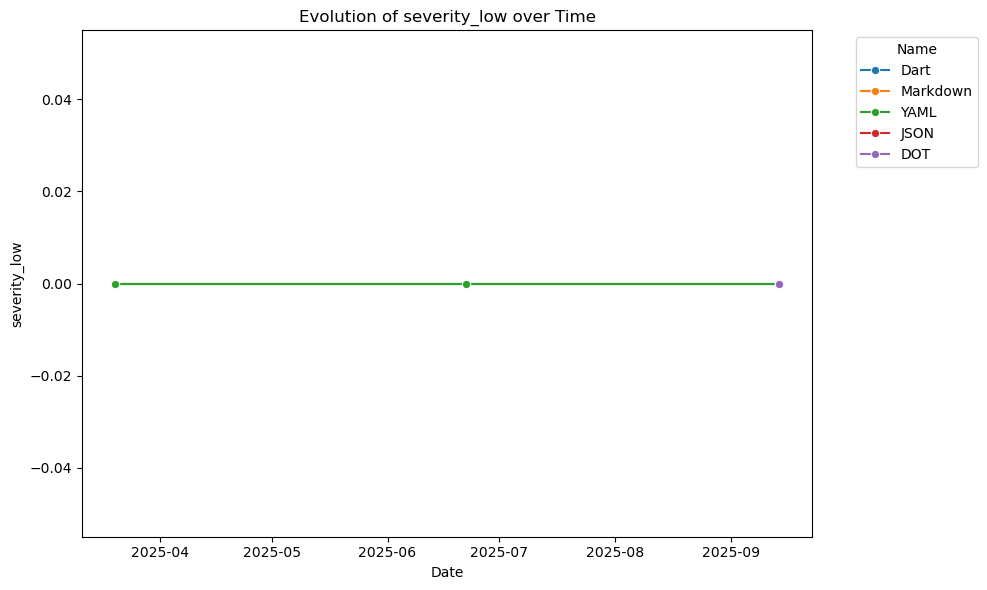

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

# Step 1: Load all matching files
file_pattern = "data/*.json"
file_paths = glob.glob(file_pattern)

records = []
for path in file_paths:
    with open(path, "r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["source_file"] = path
    records.append(df)

raw_df = pd.concat(records, ignore_index=True)

# Step 2: Convert Date to datetime
raw_df["Date"] = pd.to_datetime(raw_df["Date"])

# Step 3: List of metrics to plot individually
metrics = [
    "Projects", "Count", "tests",
    "Bytes", "Lines", "Code", "Comment", "Blank",
    "Complexity",
    "severity_high", "severity_medium", "severity_low"
]

# Step 4: One plot per metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=raw_df,
        x="Date",
        y=metric,
        hue="Name",
        marker="o"
    )
    plt.title(f"Evolution of {metric} over Time")
    plt.ylabel(metric)
    plt.xlabel("Date")
    plt.legend(title="Name", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

